In [12]:
import numpy as np
from docplex.mp.model import Model
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, QAOA, NumPyEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, \
    MinimumEigenOptimizationResult
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.applications.ising import docplex
import matplotlib.pyplot as plt

In [13]:
machines_times = [3, 6, 2]
machines_costs = [2, 5, 1]
tasks = [6, 12, 18, 24]
paths = [[0, 1, 3], [0, 2, 3]]
d = 14

In [14]:
def get_time_matrix():
    r = []
    for i in machines_times:
        tmp = []
        for j in tasks:
            tmp.append(j / i)
        r.append(tmp)
    return np.array(r)


def get_cost_matrix(tasks_execution_times):
    m = []
    for i in range(len(tasks_execution_times)):
        tmp = []
        for j in tasks_execution_times[i]:
            tmp.append(machines_costs[i] * j)
        m.append(tmp)
    return m

In [15]:
time_matrix = np.array(get_time_matrix())
cost_matrix = np.array(get_cost_matrix(time_matrix))

In [16]:
print("Time matrix:\n {}".format(time_matrix))

Time matrix:
 [[ 2.  4.  6.  8.]
 [ 1.  2.  3.  4.]
 [ 3.  6.  9. 12.]]


In [17]:
print("Cost matrix:\n {}".format(cost_matrix))

Cost matrix:
 [[ 4.  8. 12. 16.]
 [ 5. 10. 15. 20.]
 [ 3.  6.  9. 12.]]



In this specific situation there are:


1.   two qubits for each task: **8 qubits**,
2.   first path minimum time is *1+2+4=7*. *log2(14-7)=log2(7)*: **3 qubits**,
3.   second path minimum time is *1+3+4=8*. *log2(14-8)=log2(6)*: **3 qubits**.


In total, the model has **14 variables**.

Model with:
 

1.   13 variables needs 4 GiB of RAM
2.   14 variables needs 16 GiB of RAM 
3.   15 variables needs 64 GiB of RAM



In [18]:
# Correct only for three machines!
correct_machines = ['00', '01', '11']
machine_to_index = {'00': 0, '01': 1, '11': 2}


def get_task_subvector(vector, task_index):
    x = len(machines_costs) - 1  # When 3 machines, then subvector for each task has length of 2.
    subvector = ''
    for i in range(2 * task_index, 2 * task_index + x):
        bit_value = str(int(vector[i]))
        subvector += bit_value
    return subvector


def solution_vector_correct(vector):
    for i in range(len(tasks)):
        if get_task_subvector(vector, i) not in correct_machines:
            return False
    return True


def execution_times_not_bigger_than_deadline(vector):
    for path in paths:
        path_time_sum = 0
        for task in path:
            task_machine = machine_to_index.get(get_task_subvector(vector, task))
            path_time_sum += time_matrix[task_machine, task]
        if path_time_sum > d:
            return False

    return True


def is_solution_correct(vector):
    return solution_vector_correct(vector) and execution_times_not_bigger_than_deadline(vector)

In [19]:
def print_solutions_with_inreasing_energy(hamiltonian):
    eigensolver = NumPyEigensolver(hamiltonian, 100)
    eigensolver_result  = eigensolver.compute_eigenvalues()

    print("Vector\t\t\tEnergy\t\t\tCorrect?")
    for eigenstate, eigenvalue in zip(eigensolver_result.eigenstates, eigensolver_result.eigenvalues):
        eigenstate, = eigenstate.sample().keys()
        eigenstate = eigenstate[::-1]
        print("{}\t\t{}\t\t{}".format(eigenstate, eigenvalue, is_solution_correct(eigenstate)))

In [20]:
def get_quadratic_problem():
    tasks_count = len(tasks)  
    machines_count = len(machines_costs) 

    mdl = Model(name='workflow')
    x = {(i, j): mdl.binary_var(name='x_{0}_{1}'.format(i, j)) 
        for i in range(0, tasks_count) for j in range(0, machines_count - 1)}

    objective = mdl.sum(cost_matrix[2, i] * x[(i, 0)]
                        + cost_matrix[1, i] * (x[(i, 1)] - x[(i, 0)]) ** 2
                        + cost_matrix[0, i] * (1 - x[(i, 1)]) for i in range(0, tasks_count))
    mdl.minimize(objective)

    for k in range(0, len(paths)):
        mdl.add_constraint(mdl.sum([time_matrix[2, i] * x[(i, 0)]
                                    + time_matrix[1, i] * (x[(i, 1)] - x[(i, 0)])
                                    + time_matrix[0, i] * (1 - x[(i, 1)])
                                    for i in paths[k]]) <=  d, "deadline_path_{}".format(k))
        
    qp = QuadraticProgram()
    qp.from_docplex(mdl)

    converter = QuadraticProgramToQubo()
    qubo = converter.convert(qp)
    H, _ = qubo.to_ising()

    print_solutions_with_inreasing_energy(H)

    return qp

In [21]:
operator = get_quadratic_problem()

Vector			Energy			Correct?
01111101110000		(-53542.5+0j)		True
11110001100100		(-53541.5+0j)		True
00110001010010		(-53540.5+0j)		True
01001101101000		(-53540.5+0j)		True
01110001110001		(-53539.5+0j)		True
11000001110100		(-53539.5+0j)		True
01110001110110		(-53539.5+0j)		True
00000100000100		(-53539.5+0j)		True
00000001001010		(-53538.5+0j)		True
11110101100101		(-53538.5+0j)		True
01011101111000		(-53538.5+0j)		True
11010100100000		(-53538.5+0j)		True
01000100100010		(-53538.5+0j)		True
00110101010011		(-53537.5+0j)		True
01000001101110		(-53537.5+0j)		True
01000001101001		(-53537.5+0j)		True
00010100010100		(-53537.5+0j)		True
11010001101100		(-53537.5+0j)		True
01010100110010		(-53536.5+0j)		True
00010001011010		(-53536.5+0j)		True
11000101110101		(-53536.5+0j)		True
01110101110111		(-53536.5+0j)		True
01010001111001		(-53535.5+0j)		True
01010001111110		(-53535.5+0j)		True
00000101001011		(-53535.5+0j)		True
01000101101111		(-53534.5+0j)		True
11010101101101		(-53534.5+0j)		True
0

In [22]:
aqua_globals.random_seed = 10598
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                    seed_simulator=aqua_globals.random_seed,
                                    seed_transpiler=aqua_globals.random_seed)
reps = 2
max_trials = 1000
entanglement = 'full'

exact_mes = NumPyMinimumEigensolver()
spsa = SPSA(maxiter=max_trials)
ry = RealAmplitudes(operator.get_num_binary_vars(), reps=reps, entanglement=entanglement)
vqe_mes = VQE(quantum_instance=quantum_instance, var_form=ry, optimizer=spsa)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.])

In [23]:
exact = MinimumEigenOptimizer(exact_mes)
vqe = MinimumEigenOptimizer(vqe_mes)
qaoa = MinimumEigenOptimizer(qaoa_mes)
recursive = RecursiveMinimumEigenOptimizer(min_eigen_optimizer=qaoa, min_num_vars=8, min_num_vars_optimizer=exact)

In [24]:
def perform_optimization(optimization, qubit_op, name):
    result = optimization.solve(qubit_op)
    print_optimization_output(result, name)

def print_optimization_output(result, solver_name):
    print("------ %s ------" % solver_name)
    print(result)
    print("Is the found vector correct? : {}".format(is_solution_correct(result.x)))
    if type(result) is MinimumEigenOptimizationResult:
        print("Most probable sample: {}".format(max(result.samples, key=lambda item: item[2])))     
        print("Lowest energy smple: {}".format(min(result.samples, key=lambda item: item[1])))
        print("Samples count: {}\n\n".format(len(result.samples)))

        plt.figure(figsize=(20,10))   
        for vector, energy, _ in result.samples:
            color = "green" if is_solution_correct(vector) else "red"
            plt.axvline(x=energy, color=color)
        plt.xlabel("Energy")
        plt.ylabel("")
        plt.show()

------ Numpy Eigensolver ------
optimal function value: 40.0
optimal value: [0. 1. 1. 1. 1. 1. 0. 1.]
status: SUCCESS
Is the found vector correct? : True
Most probable sample: ('01111101110000', 40.0, 1.0)
Lowest energy smple: ('01111101110000', 40.0, 1.0)
Samples count: 1




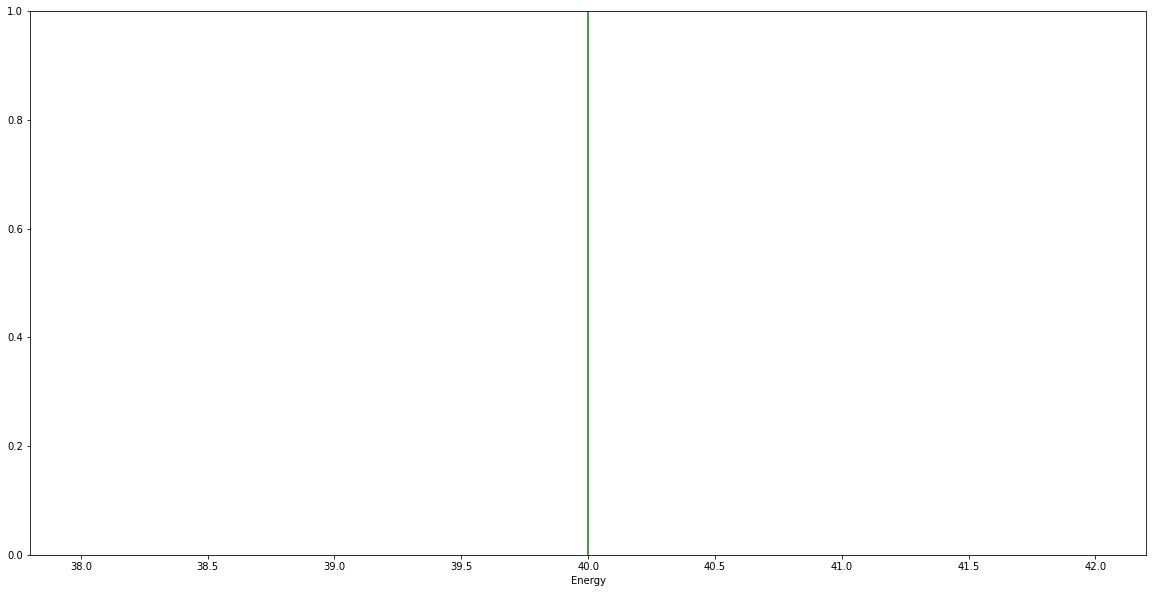

CPU times: user 494 ms, sys: 313 ms, total: 808 ms
Wall time: 492 ms


In [25]:
%%time
perform_optimization(exact, operator, "Numpy Eigensolver")

------ VQE ------
optimal function value: 40.0
optimal value: [0. 1. 1. 1. 1. 1. 0. 1.]
status: SUCCESS
Is the found vector correct? : True
Most probable sample: ('01110001000110', 2482.0, 0.12819736815666652)
Lowest energy smple: ('01111101110000', 40.0, 4.998131716144465e-06)
Samples count: 1144




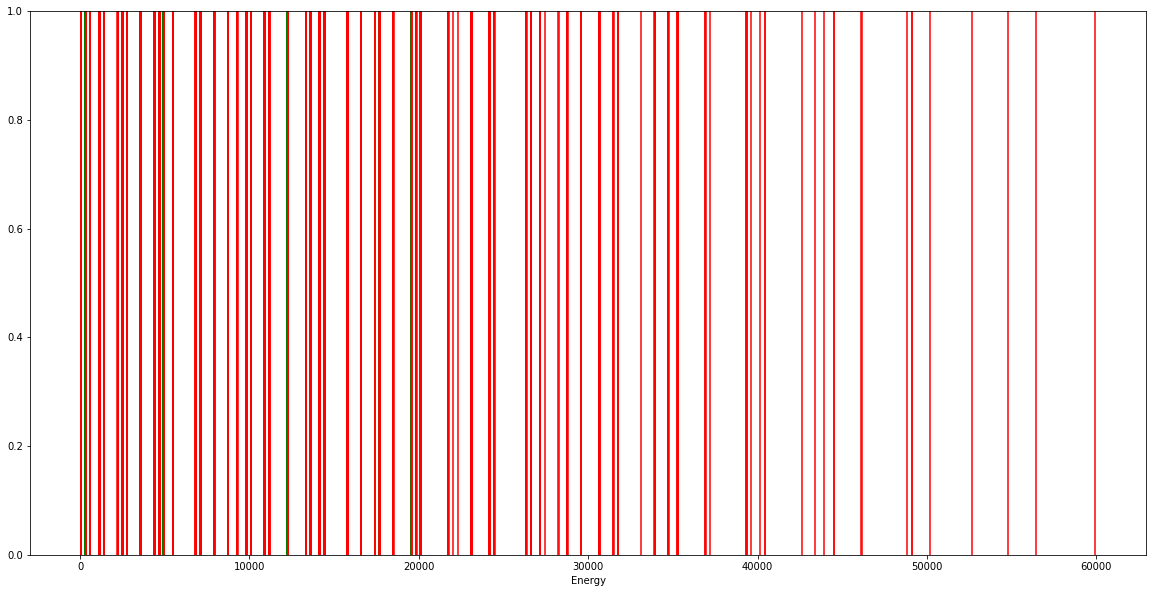

CPU times: user 1h 2min 25s, sys: 16min 31s, total: 1h 18min 56s
Wall time: 55min 15s


In [ ]:
%%time
perform_optimization(vqe, operator, "VQE")

------ QAOA ------
optimal function value: 40.0
optimal value: [0. 1. 1. 1. 1. 1. 0. 1.]
status: SUCCESS
Is the found vector correct? : True
Most probable sample: ('01110101001010', 4653.0, 0.0023525615712840404)
Lowest energy smple: ('01111101110000', 40.0, 5.062258163994459e-06)
Samples count: 14929




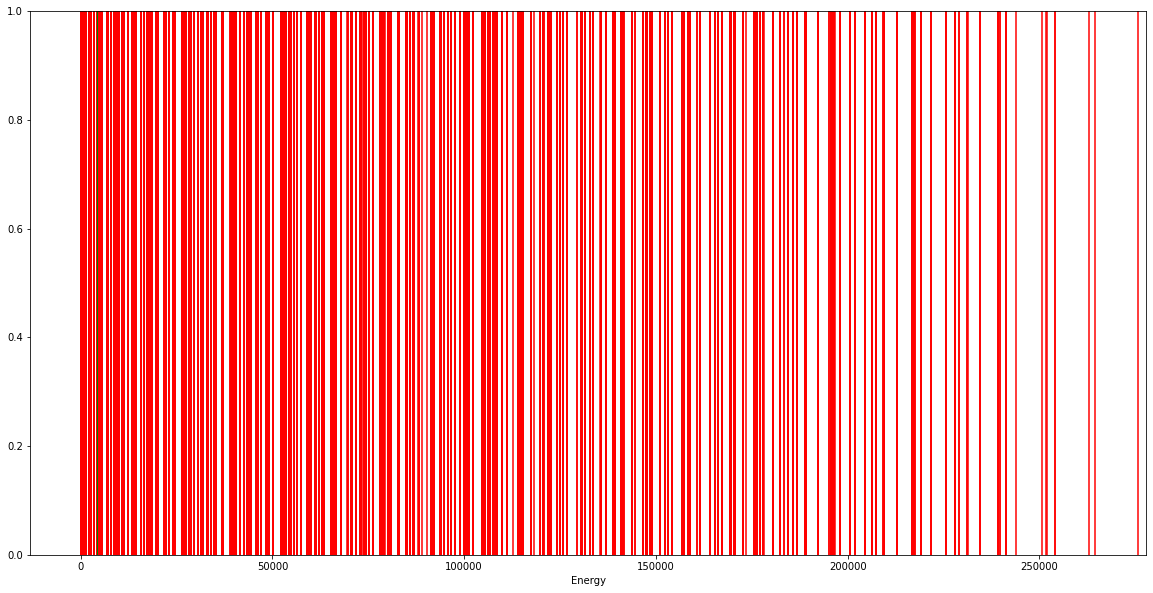

CPU times: user 16min 15s, sys: 1min 35s, total: 17min 51s
Wall time: 16min 50s


In [ ]:
%%time
perform_optimization(qaoa, operator, "QAOA")

In [26]:
%%time
perform_optimization(recursive, operator, "Recursive")

constraint deadline_path_0 is infeasible due to substitution


------ Recursive ------
optimal function value: 43.0
optimal value: [1. 1. 0. 0. 0. 0. 0. 1.]
status: SUCCESS
Is the found vector correct? : True
CPU times: user 23min 38s, sys: 3min 15s, total: 26min 53s
Wall time: 25min 47s
